# IBM Developer Skills Network

# Linear classifier with PyTorch

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import os
import glob
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
from torch import optim

# Dataset Class

In [2]:
class Dataset(Dataset):

    # Constructor
    def __init__(self, transform=None, train=True):
        directory = r'G:\Google Drive\My learning courses\AI Capstone project with Deep Learning\resources\data'
        positive = 'Positive'
        negative = 'Negative'

        positive_file_path = os.path.join(directory, positive)
        negative_file_path = os.path.join(directory, negative)

        positive_files=[os.path.join(positive_file_path,file) for file in  os.listdir(positive_file_path) if file.endswith(".jpg")]
        positive_files.sort()
        negative_files=[os.path.join(negative_file_path,file) for file in  os.listdir(negative_file_path) if file.endswith(".jpg")]
        negative_files.sort()

        number_of_samples=len(positive_files)+len(negative_files)
        self.all_files = [None] * number_of_samples
        self.all_files[::2] = positive_files
        self.all_files[1::2] = negative_files

        # transform will be used on image
        self.transform = transform
        self.Y = torch.zeros([number_of_samples]).type(torch.LongTensor)
        self.Y[::2] = 1
        self.Y[1::2] = 0

        if train:
            self.all_files = self.all_files[0:30000]
            self.Y = self.Y[0:30000]
            self.len = len(self.all_files)
        else:
            self.all_files = self.all_files[30000:]
            self.Y = self.Y[30000:]
            self.len = len(self.all_files)
        
    # Get the length
    def __len__(self):
        return self.len
    
    # Getter
    def __getitem__(self, idx):
        image = Image.open(self.all_files[idx])
        y = self.Y[idx]

        # if there is transform, apply it on image
        if self.transform:
            image = self.transform(image)
        
        return image, y

# Transform Object and Dataset Object

In [3]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])

In [4]:
dataset_train = Dataset(transform=transform, train=True)
dataset_val = Dataset(transform=transform, train=False)

In [5]:
dataset_train[0][0].shape

torch.Size([3, 227, 227])

In [6]:
# image with 3 channels of size 277*277 pixels
size_of_image = 3*227*227
size_of_image

154587

<b> Create a custom module for Softmax for two classes,called model. The input size should be the <code>size_of_image</code>, you should record the maximum accuracy achieved on the validation data for the different epochs. For example if the 5 epochs the accuracy was 0.5, 0.2, 0.64,0.77, 0.66 you would select 0.77.</b>

In [7]:
learning_rate = 0.1
momentum = 0.1
batch_size = 1000
epochs = 5
torch.manual_seed(0)


In [8]:
class SoftMax(nn.Module):

    # Constructor
    def __init__(self, input_size, output_size):
        super(SoftMax, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
    
    # Prediction
    def forward(self, x):
        z = self.linear(x)
        return z

# Check GPU

In [9]:
torch.cuda.is_available()
torch.cuda.empty_cache()

In [10]:
# create a device
device = torch.device('cuda:0')
device

device(type='cuda', index=0)

In [11]:
# train the model
loss_list = []
accuracy_list = []
N_test = len(dataset_val)
batch_size = 100

model = SoftMax(size_of_image, 2)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=momentum)
criterion = nn.CrossEntropyLoss()
train_loader = DataLoader(dataset=dataset_train, batch_size=batch_size)
val_loader = DataLoader(dataset=dataset_val, batch_size=batch_size)

model.to(device)

def train_model(n_epochs):
    for epoch in range(n_epochs):
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)  # using GPU for training
            optimizer.zero_grad()
            z = model(x.view(-1, size_of_image))
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()

        correct = 0
        for x_test, y_test in val_loader:
            x_test, y_test = x_test.to(device), y_test.to(device) # using GPU
            z = model(x_test.view(-1, size_of_image))
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y_test).sum().item()

        accuracy = correct / N_test
        loss_list.append(loss.data)
        accuracy_list.append(accuracy)

train_model(epochs)

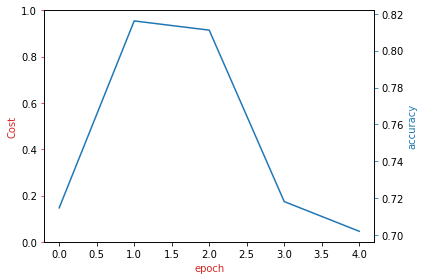

In [13]:
# Plot the accuracy

fig, ax1 = plt.subplots()
color = 'tab:red'
#ax1.plot(loss_list, color=color)
ax1.set_xlabel('epoch', color=color)
ax1.set_ylabel('Cost', color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color) 
ax2.set_xlabel('epoch', color=color)
ax2.plot( accuracy_list, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()